In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import glob
import imageio
import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torchvision

In [2]:
def fft(field):
    return torch.fft.fftshift(torch.fft.fft2(field))

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3214.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


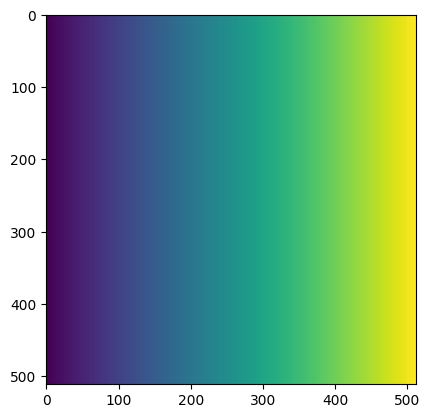

In [3]:
def get_f(shape, dx):
    ff = [torch.linspace(-1/dx/2, 1/dx/2-1/dx/s, s, dtype=torch.float32) for s in shape[-2:]]
    return torch.meshgrid(ff[0], ff[1])

dx = 6.3e-6
fy, fx = get_f((512,512),dx)
plt.imshow(fx)

In [4]:
def get_propagation_kernel(fx, fy, wl, d):
    return torch.exp(-1j * 2 * torch.pi * d * torch.sqrt(1/wl**2 - fx**2 - fy**2))

In [5]:
def ifft(HF):
    return torch.fft.ifft2(torch.fft.ifftshift(HF))

In [6]:
def propagate_field(field, H):
    F = fft(field)
    return ifft(H * F)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


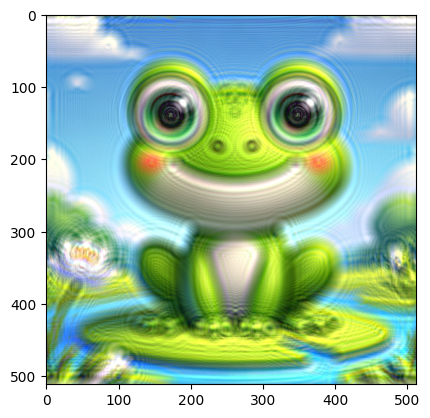

In [7]:
img = torchvision.transforms.functional.resize(torchvision.io.read_image('/home/mzmighty17/frog.png')/255, (512,512))
H = get_propagation_kernel(fx, fy, wl=515e-9, d=10e-3)
sim = propagate_field(img, H)
plt.imshow(sim.permute(1,2,0).abs())

In [8]:
# Unsupervised Learning
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=6)
H = get_propagation_kernel(fx, fy, wl=515e-9, d=-10e-3)

# 홀로그램으로 3차원 장면 재구성 -> 입력 이미지와 비교하여 가중치 계산
def back_propagate_and_compare(field, target, H):
    prop = propagate_field(field, H)
    return F.mse_loss(prop.abs(), target)

In [9]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        super().__init__()
        # folder에 있는 이미지 파일 이름들 불러오기
        self.png_files = glob.glob(folder + "*.png")
        self.png_files.sort()
        self.transform = transform
        # transform을 저장해두기
        
    def __getitem__(self, index):
        # 이미지 파일을 실제로 읽어오기
        # transform을 적용하기
        img = imageio.imread(self.png_files[index])
        if self.transform:
            img = self.transform(img)
        return img

    def __len__(self):
        # 길이 리턴하기
        return len(self.png_files)    
    
folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/'
dataset = ImageDataset(folder, transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Resize((512,512))]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

In [10]:
device = 'cuda'

model = model.to(device)
model.train()
H = get_propagation_kernel(fx, fy, wl=515e-9, d=-10e-3)
H = H.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(50):
    pbar = tqdm.tqdm(dataloader)
    for img in pbar:
        img = img.to(device)
        output = model(img)
        loss = back_propagate_and_compare(output[:,:3] + output[:,3:]*1j, img, H)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.3f}'.format(loss.item()))

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_18872/246308308.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(self.png_files[index])
0.015: 100%|██████████| 200/200 [01:29<00:00,  2.24it/s]


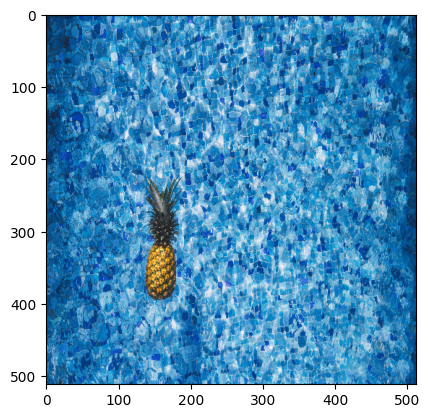

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


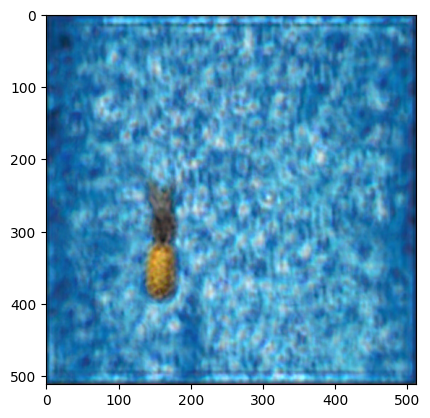

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


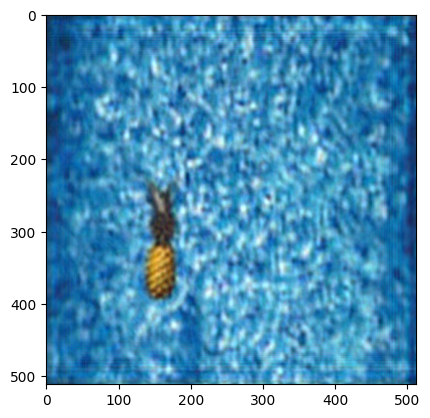

In [11]:
model.eval()
plt.imshow(img[0].permute(1,2,0).detach().cpu())
plt.show()
output = model(img)
field = output[:,:3] + output[:,3:]*1j
plt.imshow(field[0].permute(1,2,0).detach().cpu().abs())
plt.show()
backprop = propagate_field(field, H)
plt.imshow(backprop[0].permute(1,2,0).detach().cpu().abs())
plt.show()

In [12]:
# Supervised Learning
class ImageDatasetSupervised(torch.utils.data.Dataset):
    def __init__(self, image_folder, dx, wl, d, transform=None):
        super().__init__()
        self.image_files = glob.glob(image_folder + "*.png")
        self.image_files.sort()
        self.transform = transform
        self.dx = dx
        self.wl = wl
        self.d = d
        # 주파수 성분 계산
        self.fx, self.fy = get_f((512, 512), dx)
        self.H = get_propagation_kernel(self.fx, self.fy, wl, d)
    def __getitem__(self, index):
        img = imageio.v2.imread(self.image_files[index])
        if self.transform:
            img = self.transform(img)
        holo = self.generate_hologram(img)
        return img, holo
    def __len__(self):
        return len(self.image_files)
    def generate_hologram(self, img):
        holo = propagate_field(img, self.H)
        # 홀로그램 데이터를 6채널로 확장합니다. (복소수 실수부와 허수부로 분리)
        holo_6ch = torch.cat((holo.real, holo.imag), dim=0)
        return holo_6ch

# 데이터셋 및 데이터로더
image_folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/'
dx = 6.3e-6
wl = 515e-9
d = 10e-3
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])


dataset = ImageDatasetSupervised(image_folder, dx, wl, d, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
# 모델 및 학습 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
new_model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=6)  # 출력 채널을 6으로 유지
new_model = new_model.to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()
# 학습 루프
num_epochs = 50
for epoch in range(num_epochs):
    pbar = tqdm.tqdm(dataloader)
    for img, holo in pbar:
        img = img.to(device)
        holo = holo.to(device)
        # print(f'img size: {img.size()}, holo size: {holo.size()}')
        output = new_model(img)  # 출력 홀로그램
        # 복소수 손실을 계산하기 위해 실수부와 허수부를 나눔
        output_real = output[:, :3, :, :].float()
        output_imag = output[:, 3:, :, :].float()
        holo_real = holo[:, :3, :, :].float()
        holo_imag = holo[:, 3:, :, :].float()
        # 실수부와 허수부에 대해 각각 손실 계산
        loss_real = criterion(output_real, holo_real)  # 실수부
        loss_imag = criterion(output_imag, holo_imag)  # 허수부
        # 총 손실 계산
        loss = loss_real + loss_imag
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 50/50, Loss: 0.0108: 100%|██████████| 200/200 [01:29<00:00,  2.24it/s]


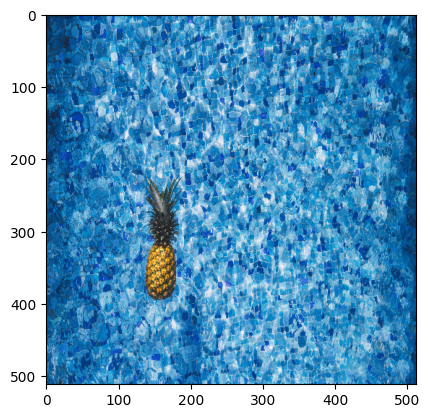

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


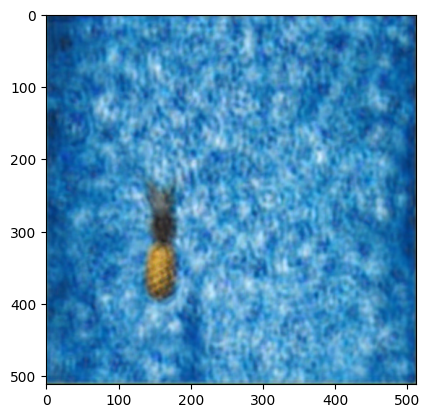

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


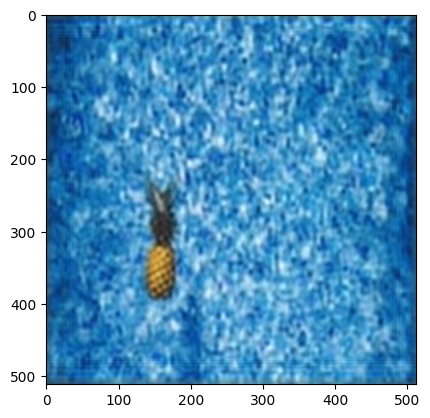

In [13]:
new_model.eval()
plt.imshow(img[0].permute(1,2,0).detach().cpu())
plt.show()
output = new_model(img)
field = output[:,:3] + output[:,3:]*1j
plt.imshow(field[0].permute(1,2,0).detach().cpu().abs())
plt.show()
backprop = propagate_field(field, H)
plt.imshow(backprop[0].permute(1,2,0).detach().cpu().abs())
plt.show()